<a href="https://colab.research.google.com/github/vamsi7964/time-series/blob/main/Time_Series_Forecasting_ML_DL_Statistical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Time Series forecasting
****
#### This project uses time-series methods to forecast store sales. The data is gathered from a kaggle competition https://www.kaggle.com/c/store-sales-time-series-forecasting/data
#### I leveraged classical methods like ARIMA, ETS and deep learning models like LSTMs/Transformers to generate the forecasts
#### Also implemented data transformation steps to do differencing and seasonal decomposition which are standard in classical models. I also tried to give an account of strengths and limitations of each forecasting method.
#### The evaluation metric for this competition is Root Mean Squared Logarithmic Error.
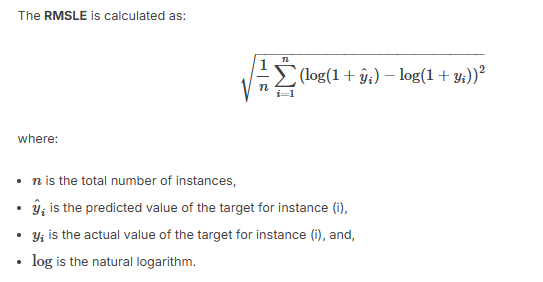

In [1]:
#Only if you are running on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### Read datasets

In [3]:
df_train = pd.read_csv('./drive/MyDrive/Data/Store_Sales/train.csv')
df_test = pd.read_csv('./drive/MyDrive/Data/Store_Sales/test.csv')
df_holiday_events = pd.read_csv('./drive/MyDrive/Data/Store_Sales/holidays_events.csv')
df_oil = pd.read_csv('./drive/MyDrive/Data/Store_Sales/oil.csv')
df_stores = pd.read_csv('./drive/MyDrive/Data/Store_Sales/stores.csv')
df_transactions = pd.read_csv('./drive/MyDrive/Data/Store_Sales/transactions.csv')
df_submission = pd.read_csv('./drive/MyDrive/Data/Store_Sales/sample_submission.csv')

### Explore data

In [5]:
df_train.shape, df_test.shape

((3000888, 6), (28512, 5))

In [6]:
df_stores.shape, df_transactions.shape, df_oil.shape, df_holiday_events.shape

((54, 5), (83488, 3), (1218, 2), (350, 6))

In [7]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [11]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### Check for missing values

In [12]:
print("Missing values in train dataset:")
print(df_train.isnull().sum().any())
print("Missing values in stores dataset:")
print(df_stores.isnull().sum().any())
print("Missing values in transactions dataset:")
print(df_transactions.isnull().sum().any())
print("Missing values in oil dataset:")
print(df_oil.isnull().sum().any())
print("Missing values in holiday events dataset")
print(df_holiday_events.isnull().sum().any())

Missing values in train dataset:
False
Missing values in stores dataset:
False
Missing values in transactions dataset:
False
Missing values in oil dataset:
True
Missing values in holiday events dataset
False


#### `Missing values found in oil dataset`

### EDA

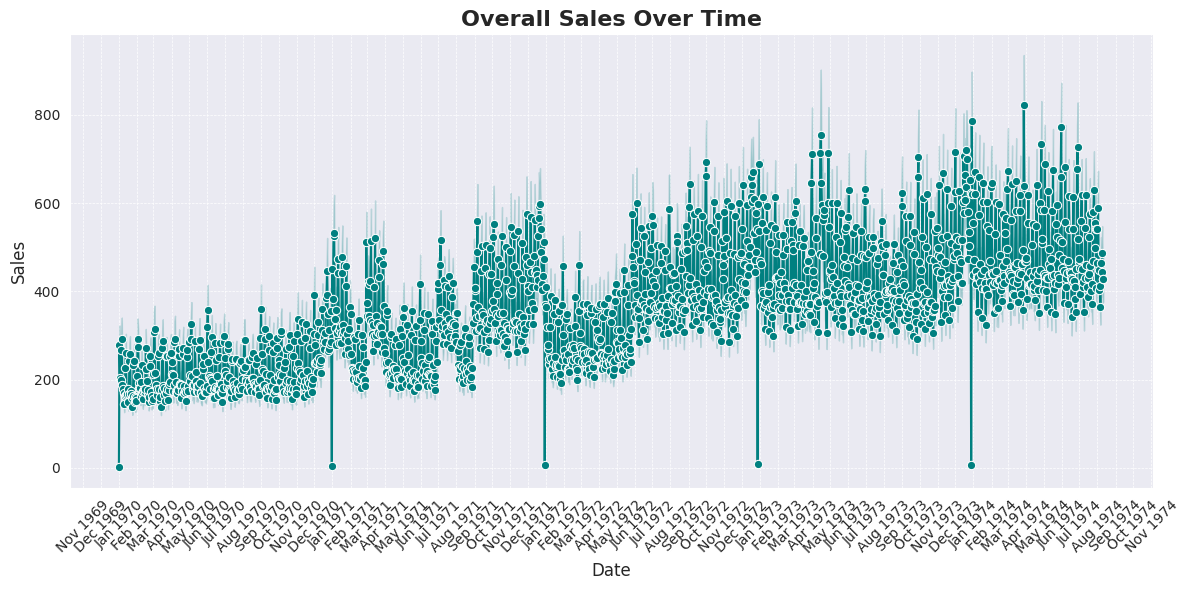

In [13]:
# Plot sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train, x='date', y='sales', color='teal', marker="o")

# Customize x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Customize the plot for aesthetics
plt.title("Overall Sales Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

### `The trend plot of sales shows a seasonal additive model over time. we can see that there is a dip towards the end of each year. `

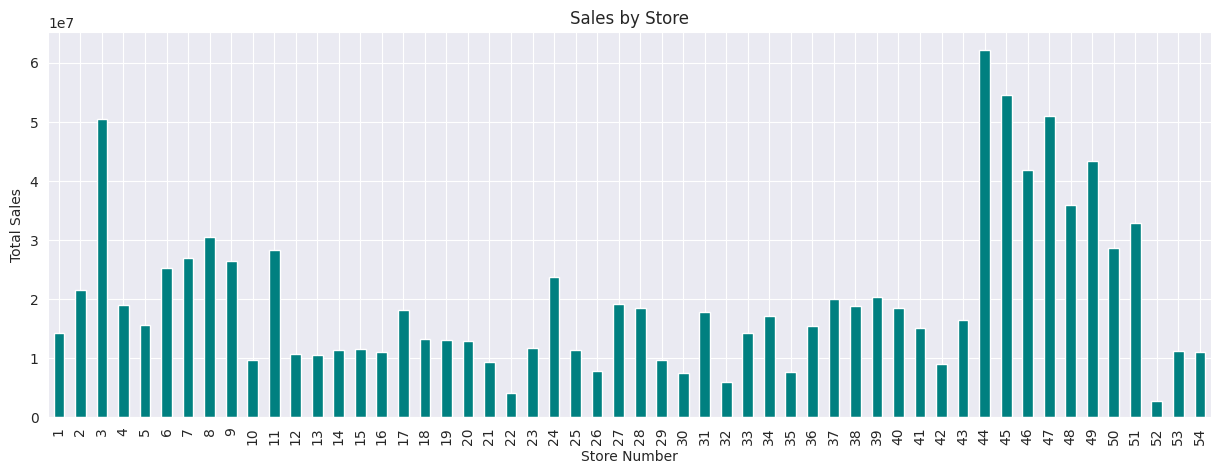

In [14]:
# Plot total sales by store
plt.figure(figsize=(15, 5))
df_train.groupby('store_nbr')['sales'].sum().plot(kind='bar', color='teal')
plt.title("Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.show()

### Total sales across stores shows that some stored have high volumes more than the others. But if we want to dive deeper, do the stores with high volumes have consistent trend or is it caused by some intermittent spikes?

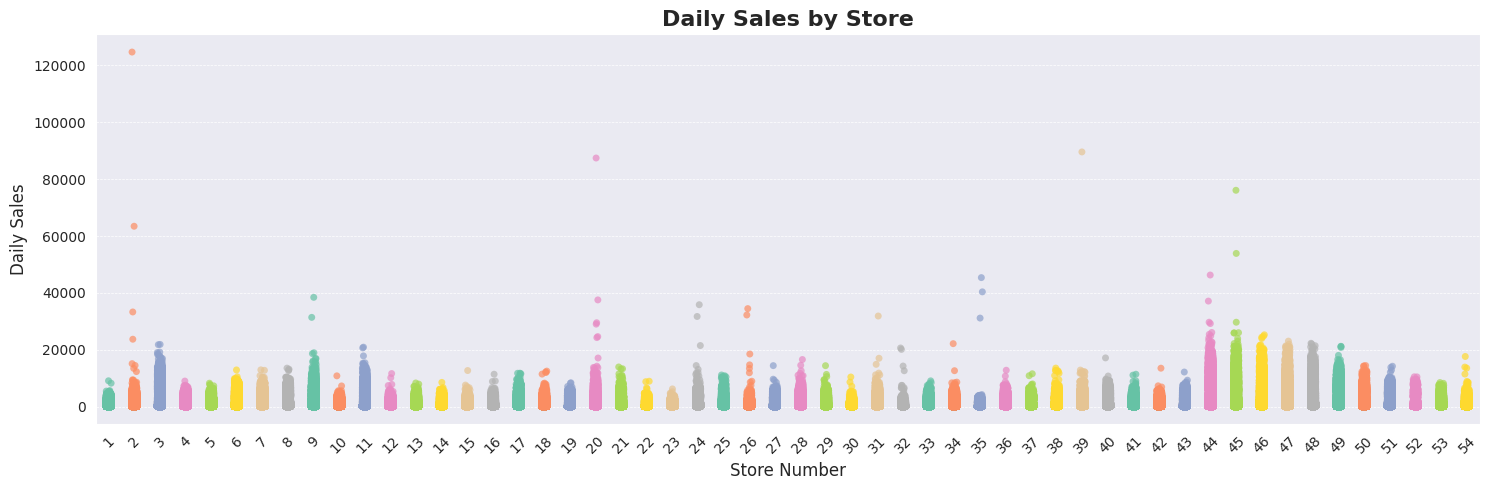

In [15]:
# Plot jitter plot of daily sales by store
plt.figure(figsize=(15, 5))
sns.stripplot(
    data=df_train,
    x='store_nbr',
    y='sales',
    jitter=True,
    palette='Set2',
    alpha=0.7
)

# Customize the plot for aesthetics
plt.title("Daily Sales by Store", fontsize=16, fontweight='bold')
plt.xlabel("Store Number", fontsize=12)
plt.ylabel("Daily Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

### `Some stores like 2, 20, 39 and 45 have some days where sales peaked. But it doesn't look like it has much impact on overall sales`

In [16]:
# get summary stats by store
display(df_train.groupby('store_nbr').agg({'sales':['mean','median','std','min','max']}).reset_index())


store_nbr        sales                                       
                     mean   median          std  min         max
0          1   254.534889  19.0000   596.827146  0.0    9065.000
1          2   387.918172  23.2170  1079.560490  0.0  124717.000
2          3   908.405495  64.0000  2146.185033  0.0   21858.000
3          4   340.273886  19.0000   801.128208  0.0    8969.000
4          5   280.580231  19.0000   652.588149  0.0    8216.620
5          6   453.172101  29.0000  1072.348435  0.0   12878.000
6          7   484.993334  27.2425  1139.705304  0.0   12907.000
7          8   548.734739  39.0000  1275.423965  0.0   13511.000
8          9   475.229271  18.0000  1269.620655  0.0   38422.625
9         10   172.999096   5.0000   477.274147  0.0   10801.000
10        11   509.709179  15.0000  1360.257967  0.0   20891.557
11        12   191.809148   6.0000   521.523369  0.0   11609.557
12        13   189.358775   6.0000   551.555075  0.0    8294.000
13        14   204.921881   6.0000   540.668664  0.0    8496.000
14        15   206.061866   8.0000   542.929941  0.0   12669.000
15        16   197.696908   6.0000   529.370674  0.0   11377.000
16        17   324.461406  10.0000   852.435149  0.0   11737.000
17        18   238.598137   8.0000   618.124507  0.0   12473.000
18        19   234.821670   8.0000   662.226739  0.0    8351.000
19        20   232.508360   0.0000   966.156003  0.0   87438.516
20        21   166.549808   0.0000   651.285834  0.0   13924.218
21        22    73.601845   0.0000   316.225353  0.0    8909.000
22        23   209.662792  13.0000   457.422739  0.0    6201.722
23        24   427.692592  19.0000  1018.909108  0.0   35828.000
24        25   205.517129   9.0000   561.160981  0.0   11097.000
25        26   139.550887   5.0000   420.371399  0.0   34454.000
26        27   345.282181  18.0000   814.628264  0.0   14396.000
27        28   330.798871  10.0000   852.012657  0.0   16542.902
28        29   175.001038   0.0000   607.751226  0.0   14380.789
29        30   132.838006   5.0000   347.580092  0.0   10392.000
30        31   319.349181  10.0000   834.551272  0.0   31851.158
31        32   107.100626   3.0000   334.004364  0.0   20602.000
32        33   255.137503   9.0000   642.253241  0.0    9040.000
33        34   307.542182  10.0000   791.592422  0.0   22125.000
34        35   138.139340   3.0000   470.106439  0.0   45361.000
35        36   275.722146   5.0000   739.624537  0.0   12774.617
36        37   359.365069  23.0000   844.200860  0.0   11530.000
37        38   339.379530  22.0000   838.487866  0.0   13531.000
38        39   364.431594  16.0000  1009.901343  0.0   89576.360
39        40   331.025650   9.0000   925.660872  0.0   17114.078
40        41   269.758856  16.0000   668.116228  0.0   11371.000
41        42   160.976173   0.0000   583.518136  0.0   13494.000
42        43   294.963151   7.0000   814.482888  0.0   12143.201
43        44  1117.245254  75.0000  2685.282436  0.0   46271.000
44        45   980.673908  62.0000  2384.321416  0.0   76090.000
45        46   753.905962  36.0000  1889.012915  0.0   25238.000
46        47   916.798209  51.0000  2222.316800  0.0   23024.000
47        48   646.604950  30.0000  1668.493989  0.0   22255.000
48        49   781.330450  48.0000  1897.861943  0.0   21190.000
49        50   515.601753  32.0000  1280.877685  0.0   14431.000
50        51   592.231511  27.0000  1352.209195  0.0   14179.000
51        52    48.516694   0.0000   449.115636  0.0   10462.000
52        53   201.831269   3.0000   600.435009  0.0    8443.000
53        54   198.975799   6.0000   582.223307  0.0   17614.000

### Next let's look at the sales by product family

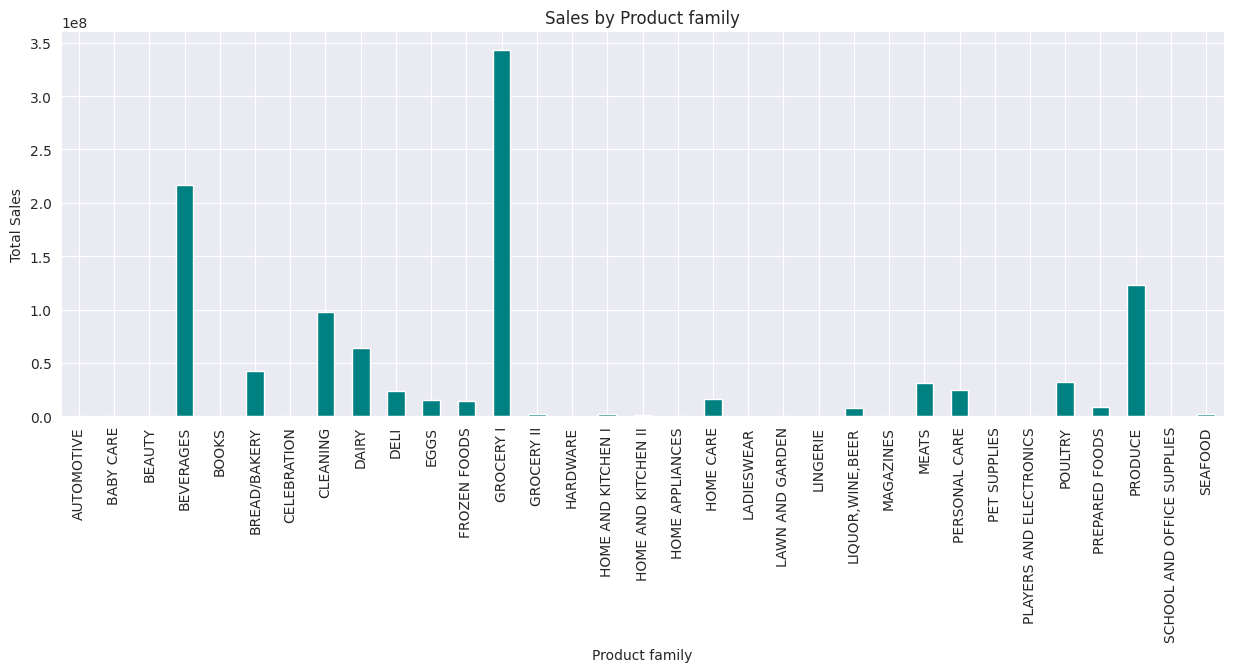

In [17]:
# Plot total sales by store
plt.figure(figsize=(15, 5))
df_train.groupby('family')['sales'].sum().plot(kind='bar', color='teal')
plt.title("Sales by Product family")
plt.xlabel("Product family")
plt.ylabel("Total Sales")
plt.show()

### `Grocery 1, Beverages and Produce have the highest total sales respectively`

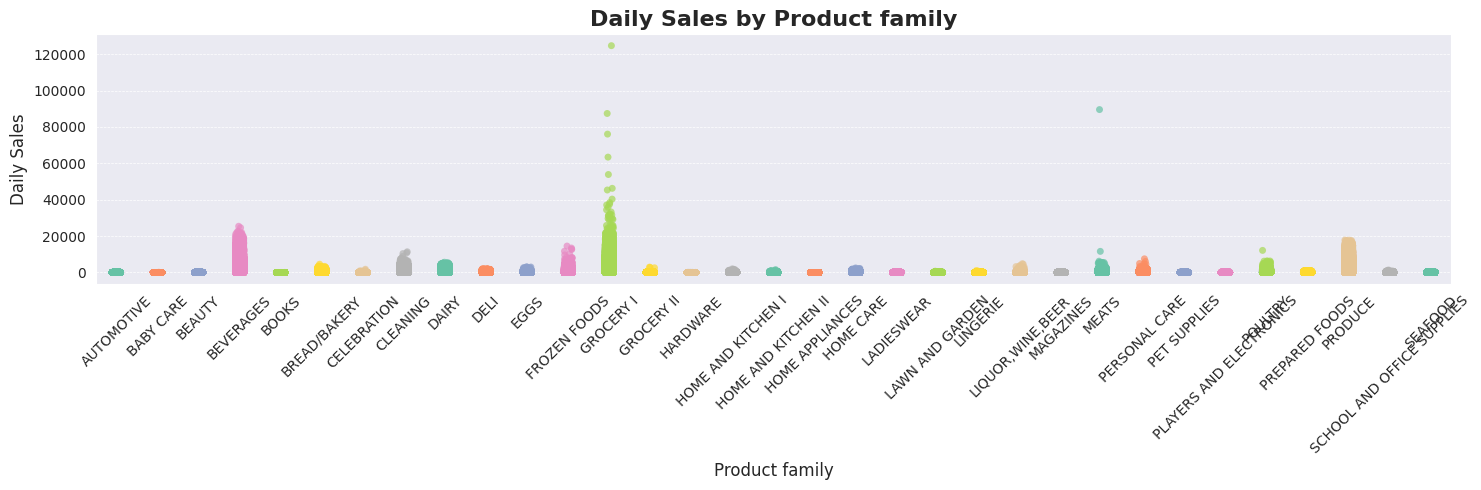

In [18]:
# Plot jitter plot of daily sales by product family
plt.figure(figsize=(15, 5))
sns.stripplot(
    data=df_train,
    x='family',
    y='sales',
    jitter=True,
    palette='Set2',
    alpha=0.7
)

# Customize the plot for aesthetics
plt.title("Daily Sales by Product family", fontsize=16, fontweight='bold')
plt.xlabel("Product family", fontsize=12)
plt.ylabel("Daily Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

### `Most of the products have consistent trends in daily sales. Except Grocery 1 which has a few spikes`

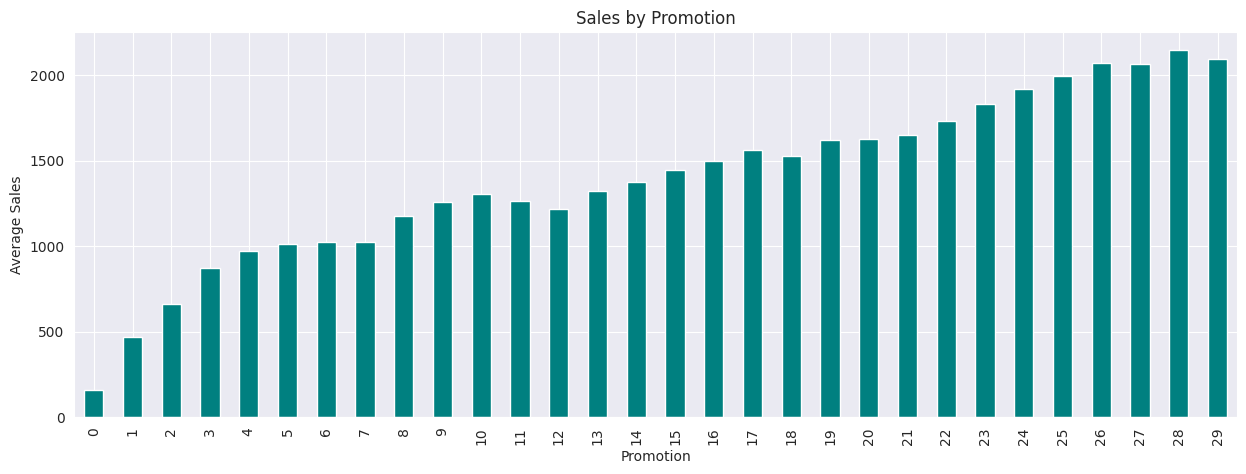

In [19]:
# Plot total sales by store
plt.figure(figsize=(15, 5))
df_train.groupby('onpromotion')['sales'].mean()[:30].plot(kind='bar', color='teal')
plt.title("Sales by Promotion")
plt.xlabel("Promotion")
plt.ylabel("Average Sales")
plt.show()

### `Based on the average sales per day, it looks like promotions are driving higher volumes`

In [20]:
# Impute missing oil prices
df_oil_clean = df_oil.copy()
df_oil_clean.set_index('date', inplace=True)
df_oil_clean['dcoilwtico'].fillna(df_oil_clean['dcoilwtico'].rolling(window=3, min_periods=1).mean(), inplace=True)

## Forecasting

In [21]:
# Grouping data by store, product, and date to create a time series for each combination
store_product_sales = df_train.groupby(['store_nbr', 'family', 'date'])['sales'].sum().reset_index()

In [22]:
# Ensure the date column is datetime for consistency
store_product_sales['date'] = pd.to_datetime(store_product_sales['date'])

In [23]:
# Create a list of unique store-product pairs
store_product_pairs = store_product_sales[['store_nbr', 'family']].drop_duplicates()


### Following code uses 3 methods to forecast sales for 30 days for each pair of store and product family.
1. ARIMA
2. Exponential Smoothing (ETS)
3. LSTM

Below is a comparative account of these models
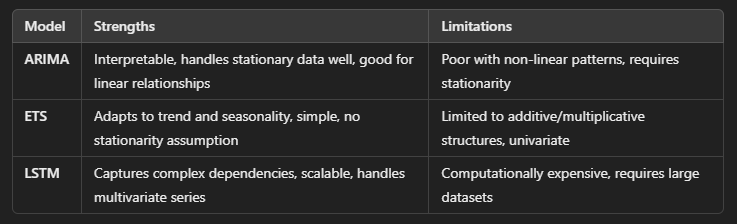

Based on the pros and cons of each of the models, below are the best usecases to leverage these models
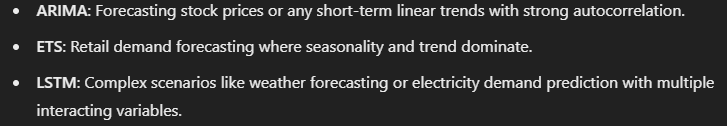

In [24]:
# Initialize a dictionary to store processed data for each store-product pair
processed_data = {}

# Process data for each store-product pair
for _, row in store_product_pairs.iterrows():
    store, product = row['store_nbr'], row['family']
    subset = store_product_sales[(store_product_sales['store_nbr'] == store) &
                                 (store_product_sales['family'] == product)].copy()

    # Sort by date to ensure proper time series structure
    subset = subset.sort_values('date')

    # Fill missing dates (if any) with zero sales for continuity
    full_dates = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='D')
    subset = subset.set_index('date').reindex(full_dates).fillna(0).rename_axis('date').reset_index()

    # Add differencing for stationarity
    subset['sales_diff'] = subset['sales'].diff()

    # Seasonal decomposition
    if subset['sales'].sum() > 0:  # Skip decomposition for products with zero sales
        decomposition = seasonal_decompose(subset['sales'], model='additive', period=365, extrapolate_trend='freq')
        subset['trend'] = decomposition.trend
        subset['seasonal'] = decomposition.seasonal
        subset['residual'] = decomposition.resid

    # Store processed data
    processed_data[(store, product)] = subset

# Check the processed data for one store-product pair
processed_sample = next(iter(processed_data.values()))
processed_sample.head()


,date,store_nbr,family,sales,sales_diff,trend,seasonal,residual
0,2013-01-01,1.0,AUTOMOTIVE,0.0,NaN,1.921995,-2.694908,0.772913
1,2013-01-02,1.0,AUTOMOTIVE,2.0,2.0,1.923387,-0.296830,0.373443
2,2013-01-03,1.0,AUTOMOTIVE,3.0,1.0,1.924780,-0.096561,1.171781
3,2013-01-04,1.0,AUTOMOTIVE,3.0,0.0,1.926172,0.700969,0.372859
4,2013-01-05,1.0,AUTOMOTIVE,5.0,2.0,1.927564,0.700143,2.372294


In [25]:
# Define PyTorch LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



In [26]:
# Initialize a dictionary to store forecasts
forecasts = {}

# Loop through each store-product pair
for (store, product), data in processed_data.items():
    # Ensure the dataset is not empty after preprocessing
    if data['sales'].sum() == 0:
        continue
    print(f"Analyzing store:{store} and product:{product}")
    # Prepare training data
    train_data = data.dropna().set_index('date')['sales']
    if len(train_data) < 30:  # Skip if insufficient data for training
        print(f"For store:{store} and product:{product} combination, there isn't enough data.")
        continue

    # Train ARIMA model
    print("Training ARIMA model...")
    arima_model = ARIMA(train_data, order=(1, 1, 1)).fit()
    arima_forecast = arima_model.forecast(steps=30)  # Forecast 30 days

    # Train ETS model
    print("Training ETS model...")
    ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365).fit()
    ets_forecast = ets_model.forecast(steps=30)

    # Prepare LSTM data
    print("Preparing LSTM data...")
    lstm_train_data = np.array(train_data).reshape(-1, 1)
    train_x = torch.tensor(lstm_train_data[:-1], dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
    train_y = torch.tensor(lstm_train_data[1:], dtype=torch.float32)

    # Initialize PyTorch model
    print("Initializing PyTorch model...")
    lstm_model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

    # Train LSTM

    for epoch in range(10):  # Adjust epochs as needed
        lstm_model.train()
        optimizer.zero_grad()
        outputs = lstm_model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        import torch

        # Forecast with LSTM
        lstm_model.eval()
        lstm_forecast = []
        input_seq = train_x[-1].unsqueeze(0)  # Last sequence of the training data
        sequence_length, input_dim = input_seq.shape[1], input_seq.shape[2]

        for _ in range(30):  # Forecast 30 days
            with torch.no_grad():
                pred = lstm_model(input_seq)  # Predict the next value

                # If pred is 2D (batch_size, feature_size), add a sequence dimension
                if pred.dim() == 2:
                    pred = pred.unsqueeze(1)  # Add a sequence length dimension

                # Append the prediction to the forecast list
                lstm_forecast.append(pred.squeeze().item())

                # Match the input dimensions
                pred = pred.expand(-1, -1, input_dim)  # Expand features to match input dimensions

                # Update input_seq: remove the oldest step and append the prediction
                input_seq = torch.cat((input_seq[:, 1:, :], pred), dim=1)  # Keep batch size and match sequence length


    # Store the forecasts
    forecasts[(store, product)] = {
        'ARIMA': arima_forecast,
        'ETS': ets_forecast,
        'LSTM': lstm_forecast
    }


Streaming output truncated to the last 5000 lines.
Analyzing store:23 and product:LIQUOR,WINE,BEER
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:MAGAZINES
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:MEATS
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:PERSONAL CARE
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:PET SUPPLIES
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:PLAYERS AND ELECTRONICS
Training ARIMA model...
Training ETS model...
Preparing LSTM data...
Initializing PyTorch model...
Analyzing store:23 and product:POULTRY
Training ARIMA model...
Training ETS model...


In [27]:

# Example to save forecasts to a CSV
all_forecasts = []
for (store, product), forecast in forecasts.items():
    for model, values in forecast.items():
        for day, value in enumerate(values):
            all_forecasts.append({'store_nbr': store, 'family': product, 'model': model, 'day': day + 1, 'forecast': value})

# Convert to DataFrame and save
forecast_df = pd.DataFrame(all_forecasts)
forecast_df.to_csv('store_product_forecasts_pytorch.csv', index=False)


In [28]:
# read the forecasts file for test data validation
forecast_df = pd.read_csv('store_product_forecasts_pytorch.csv')

### Evaluation using RMSLE

In [36]:
import numpy as np

def calculate_rmsle(y_true, y_pred):
    """
    Calculate the Root Mean Squared Logarithmic Error (RMSLE).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    squared_log_error = (log_true - log_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_error)
    return np.sqrt(mean_squared_log_error)

def evaluate_on_training_data(train_set, processed_data, models):
    """
    Evaluate the performance of ARIMA, ETS, and LSTM on training data.
    """
    performance = {}

    for (store, product), data in processed_data.items():
        # Use a portion of training data for model fitting and hold out the last 30 days
        sales_data = data['sales']
        if len(sales_data) < 60:  # Ensure enough data for training and validation
            continue

        train_data = sales_data[:-30]  # Use all but the last 30 days for training
        actuals = sales_data[-30:]    # Use the last 30 days for validation

        # Model evaluations
        model_forecasts = {}

        # ARIMA Model
        try:
            arima_model = ARIMA(train_data, order=(1, 1, 1)).fit()
            arima_forecast = arima_model.forecast(steps=30)
            model_forecasts['ARIMA'] = arima_forecast
        except Exception as e:
            model_forecasts['ARIMA'] = None

        # ETS Model
        try:
            ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365).fit()
            ets_forecast = ets_model.forecast(steps=30)
            model_forecasts['ETS'] = ets_forecast
        except Exception as e:
            model_forecasts['ETS'] = None

        # LSTM Model
        try:
            # Prepare data for LSTM
            train_x = torch.tensor(train_data.values[:-1], dtype=torch.float32).view(-1, 1, 1)
            train_y = torch.tensor(train_data.values[1:], dtype=torch.float32).view(-1, 1)

            lstm_model = models.get('LSTM')
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

            # Train LSTM
            lstm_model.train()
            for epoch in range(10):  # Adjust epochs as needed
                optimizer.zero_grad()
                outputs = lstm_model(train_x)
                loss = criterion(outputs, train_y)
                loss.backward()
                optimizer.step()

            # Forecast with LSTM
            lstm_model.eval()
            input_seq = train_x[-1].unsqueeze(0)  # Last input sequence
            lstm_forecast = []
            for _ in range(30):
                with torch.no_grad():
                    pred = lstm_model(input_seq)
                    lstm_forecast.append(pred.item())
                    input_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(1)), dim=1)

            model_forecasts['LSTM'] = lstm_forecast
        except Exception as e:
            model_forecasts['LSTM'] = None

        # Calculate RMSLE
        for model, forecast in model_forecasts.items():
            if forecast is not None and len(forecast) == len(actuals):
                rmsle = calculate_rmsle(actuals, forecast)
                performance[(store, product, model)] = rmsle

    return performance

# Example usage:
# Assuming `processed_data` contains preprocessed sales data
models = {'LSTM': LSTMModel()}  # Replace with your LSTM model
training_performance = evaluate_on_training_data(df_train, processed_data, models)

# Print results
for key, rmsle in training_performance.items():
    store, product, model = key
    print(f"Store: {store}, Product: {product}, Model: {model}, RMSLE: {rmsle:.4f}")


Streaming output truncated to the last 5000 lines.
Store: 4, Product: HOME AND KITCHEN II, Model: ETS, RMSLE: 0.4361
Store: 4, Product: HOME AND KITCHEN II, Model: LSTM, RMSLE: 0.6877
Store: 4, Product: HOME APPLIANCES, Model: ARIMA, RMSLE: 0.4458
Store: 4, Product: HOME APPLIANCES, Model: ETS, RMSLE: 0.4238
Store: 4, Product: HOME APPLIANCES, Model: LSTM, RMSLE: 2.8795
Store: 4, Product: HOME CARE, Model: ARIMA, RMSLE: 0.3996
Store: 4, Product: HOME CARE, Model: ETS, RMSLE: 0.2808
Store: 4, Product: HOME CARE, Model: LSTM, RMSLE: 2.4263
Store: 4, Product: LADIESWEAR, Model: ARIMA, RMSLE: 0.4348
Store: 4, Product: LADIESWEAR, Model: ETS, RMSLE: 0.6747
Store: 4, Product: LADIESWEAR, Model: LSTM, RMSLE: 0.4281
Store: 4, Product: LAWN AND GARDEN, Model: ARIMA, RMSLE: 0.3498
Store: 4, Product: LAWN AND GARDEN, Model: ETS, RMSLE: 0.3505
Store: 4, Product: LAWN AND GARDEN, Model: LSTM, RMSLE: 0.3586
Store: 4, Product: LINGERIE, Model: ARIMA, RMSLE: 0.6580
Store: 4, Product: LINGERIE, Model: 